Benchmark for Exercise 2: Time of execution of a VMC metropolis algorithm

In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import time 

#parameters
hbar2div2m = 20.74  # MeV * fm^2

In [2]:
# Define the inter-nucleon potential function
@njit
def potential(r2):
    return (1000.0 * np.exp(-3.0 * r2) 
            - 163.35 * np.exp(-1.05 * r2) 
            - 83.0 * np.exp(-0.8 * r2) 
            - 21.5 * np.exp(-0.6 * r2) 
            - 11.5 * np.exp(-0.4 * r2))

In [3]:
# Trial wave function for 4He
@njit
def trial_wave_function(positions, a, beta, gamma):
    n_particles = positions.shape[0]
    psi = 1.0
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            r2 = np.sum((positions[i] - positions[j]) ** 2)
            correlation = np.exp(-gamma * r2) - a * np.exp(-(beta + gamma) * r2)
            psi *= correlation
    return psi

In [4]:

# Local energy calculation
@njit
def local_energy(positions, a, beta, gamma):
    n_particles = positions.shape[0]
    # Potential part
    V = 0.0
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            r2 = np.sum((positions[i] - positions[j]) ** 2)
            V += potential(r2)

    # Kinetic energy part
    psi = trial_wave_function(positions, a, beta, gamma)
    grad_psi = 0.0 # Initializing wave function gradient
    delta = 1e-5  # Delta size for kinetic energy approximate calculation

    # Evaluating psi in two points and take the difference
    for i in range(n_particles):
        for j in range(3):  # They are 3D coordinates
            positions[i, j] += delta
            psi_plus = trial_wave_function(positions, a, beta, gamma)
            positions[i, j] -= 2 * delta
            psi_minus = trial_wave_function(positions, a, beta, gamma)
            positions[i, j] += delta  # Restore original position
            
            grad_psi += (psi_plus - 2 * psi + psi_minus) / (delta ** 2)
    
    kinetic_energy = -hbar2div2m * grad_psi / psi
    return kinetic_energy + V


In [6]:
# Main Variational Monte Carlo function with parameter optimization
@njit
def variational_monte_carlo(n_particles=4, n_steps=1000, thermalization_steps=300, a=0.1, beta=0.1, gamma=0.1):
    positions = np.random.normal(0, 5, (n_particles, 3))  # Random initial positions
    energy_samples = []

    # Thermalization phase (accepted steps without recording the resulting energy)
    for _ in range(thermalization_steps):
        # Proposing new positions
        new_positions = positions + np.random.normal(0, 0.5, positions.shape)
        psi_old = trial_wave_function(positions, a, beta, gamma)
        psi_new = trial_wave_function(new_positions, a, beta, gamma)
        
        # Define the metropolis acceptance condition
        acceptance_ratio = (psi_new / psi_old) ** 2
        if np.random.rand() < acceptance_ratio:
            positions = new_positions  # Accepting step
    
    # Main sampling phase
    for step in range(n_steps):
        # Proposing new positions
        new_positions = positions + np.random.normal(0, 0.5, positions.shape)
        psi_old = trial_wave_function(positions, a, beta, gamma)
        psi_new = trial_wave_function(new_positions, a, beta, gamma)
        
        # Define the metropolis acceptance condition
        acceptance_ratio = (psi_new / psi_old) ** 2
        if np.random.rand() < acceptance_ratio:
            positions = new_positions  # Accepting step
        
        E_local = local_energy(positions, a, beta, gamma)
        energy_samples.append(E_local)

    # Converting energy_samples to a NumPy array, for compatibility issues with numba.
    energy_samples = np.array(energy_samples)

    # Computing the mean energy - and it's variance - over all the VMC steps
    mean_energy = np.mean(energy_samples)
    std_error = np.std(energy_samples) / np.sqrt(n_steps)
    
    return mean_energy, std_error


In [10]:
# Fixed parameters from Guardiola's article
a_fixed = 0.7191
gamma_fixed = 0.08597
beta_fixed = 2.13796 - gamma_fixed


In [11]:
# Runtime analisys 

# Define the range for n_steps
n_steps_values = range(1000, 6001, 100)
run_times = []


# Loop through each n_steps value and measure execution time
for na_steps in n_steps_values:
    start_time = time.time()  # Start timing
    mean_energy, std_error = variational_monte_carlo(n_particles=4, n_steps=na_steps, thermalization_steps=300, a=a_fixed, beta=beta_fixed, gamma=gamma_fixed)
    end_time = time.time()  # End timing
    run_times.append(end_time - start_time)  # Calculate and store the run time


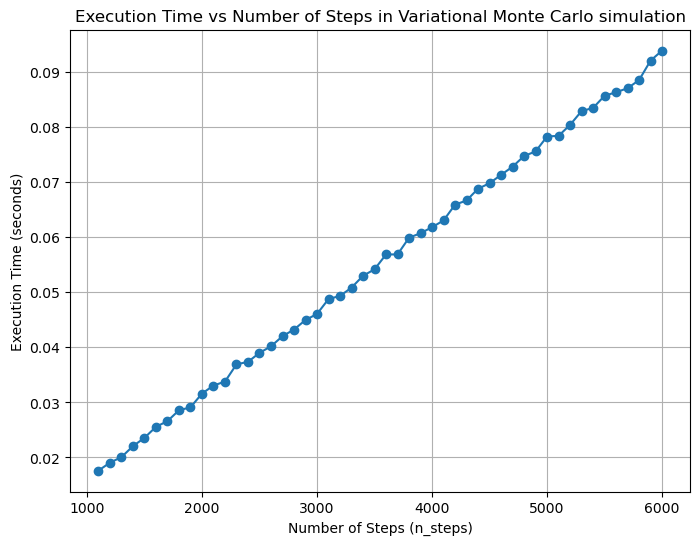

In [14]:
# Plot the results: run time vs n_steps (excluding the first point)
plt.figure(figsize=(8, 6))
plt.plot(n_steps_values[1:], run_times[1:], marker='o')  # Starting from the second element
plt.xlabel('Number of Steps (n_steps)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Number of Steps in Variational Monte Carlo simulation')
plt.grid(True)
plt.show()


